In [1]:
import torchvision
import tensorflow as tf

In [0]:
#%cd /content/
#!/usr/bin/python
# essential imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


import imageio
import cv2
import os
import sys
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion() 
import numpy as np
import timeit
import pandas as pd
import re
import math
import copy
import pickle
#tensorflow 1.15
import tensorflow as tf
#print(tf.__version__)
import torch
from sklearn.model_selection import train_test_split

# default seeding for reproducability
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [3]:
# Import torch Libraries
import torch
from torch import optim, nn
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F

from torch.nn import Linear, ReLU, CrossEntropyLoss, MSELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
#from torch.autograd import Variable
from torch.optim import Adam, SGD
from torch.optim import lr_scheduler
#adam sgd combined optimizer
!pip install adabound
import adabound
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import copy

#defaults
PIXEL_LENGTH_MODIFIED = 128
FEATURE_SIZE_MODIFIED = PIXEL_LENGTH_MODIFIED*PIXEL_LENGTH_MODIFIED
PIXEL_LENGTH_MNIST = 28
FEATURE_SIZE_MNIST = PIXEL_LENGTH_MNIST*PIXEL_LENGTH_MNIST

## helpers

In [0]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
# def normalize_max(images):
#   images_normalize=[]
#   for i in images:
#     i -= i.min()
#     denom = i.max()-i.min()
#     images_normalize.append(np.divide(i, denom))
#   return np.asarray(images_normalize) 

# def standardize_mean(images):
#   images_standardize=[]
#   for i in images:
#     mean, std = i.mean(), i.std()
#     i = (i - mean) / std
#     images_standardize.append(i)
#   return np.asarray(images_standardize) 
  
# training/testing functions
def train(epoch, train_loader, model, error, optimizer, batch_size):
    model.train()
    running_loss = 0.0
    #loss_total = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        #peak at tensor details
        # if batch_idx==1:
        #   # visualize one of the images in data set
        #   plt.imshow(np.squeeze(images[0].numpy()), cmap='Greys')
        #   plt.axis("off")
        #   plt.title(str(labels[0].numpy()))
        #   #plt.savefig('graph.png')
        #   plt.show()
        #reshape for training
        train = images.view(batch_size,3,32,32).to(device=device, dtype=torch.float)
        labels = labels.to(device=device, dtype=torch.long)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        #print(loss)
        #loss_total += loss.item()

        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        #print every 100 batches
        running_loss += loss.item()
        if batch_idx % 100 == 0 and batch_idx != 0:
            # plt.imshow(images[0].numpy().reshape(128,128))
            # plt.axis('off')
            # plt.show()
            #Print Loss
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), running_loss/100))
            running_loss = 0.0
    #loss_total /= len(train_loader)
    #print('Test set: Test loss: {:.4f}'.format(loss_total))
    #return last loss
    return loss.item()

def test(test_loader, model, error, batch_size):
    # Validation
    with torch.no_grad():
        model.eval()
        # Calculate Accuracy         
        correct = 0
        loss_test = 0.0
        # Iterate through test dataset
        for batch_idx, (images, labels) in enumerate(test_loader):
            # if batch_idx==1:
            #   # visualize one of the images in data set
            #   plt.imshow(np.squeeze(images[0].numpy()), cmap='Greys')
            #   plt.axis("off")
            #   plt.title(str(labels[0].numpy()))
            #   #plt.savefig('graph.png')
            #   plt.show()

            test = images.view(batch_size,3,32,32).to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)
            # Forward propagation
            outputs = model(test)
            

            # sum up batch loss
            loss_test += error(outputs, labels).item()
            # get the index of the max log-probability
            predicted = outputs.max(1, keepdim=True)[1]
            # if batch_idx==1:
            #   print(predicted[0].item())
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
        loss_test /= len(test_loader)
        accuracy = 100. * correct / len(test_loader.dataset)
        print('\nTest set: Test loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(loss_test, correct, len(test_loader.dataset), accuracy))
        #return loss and accuracy
        return loss_test, accuracy
        

In [5]:
# batch_size = 50
# workers = os.cpu_count()

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# lengths = [60000*0.8, 60000*0.1, 60000*0.1]

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=workers)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=workers)

# #check for gpu/cpu
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 50
workers = os.cpu_count()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

lengths = [5000, 5000]

fullset_train = torchvision.datasets.CIFAR10(root='./data', download=True, train=True,
                                       transform=transform)

fullset_test = torchvision.datasets.CIFAR10(root='./data', download=True, train=False,
                                       transform=transform)

testset, finaltestset = torch.utils.data.random_split(fullset_test, lengths)

train_loader = torch.utils.data.DataLoader(fullset_train, batch_size=batch_size,
                                          shuffle=True, num_workers=workers)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

final_test_loader = torch.utils.data.DataLoader(finaltestset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

#check for gpu/cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

0it [00:00, ?it/s]

170500096it [00:06, 26929928.55it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
fullset_test

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [0]:
# %%time
# # load mnist dataset
# (x_train_stack, y_train_stack), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# # split train into train-val set
# #x_train_stack_normalized = standardize_mean(x_train_stack)
# features_train, features_test, targets_train, targets_test = train_test_split(x_train_stack,
#                                                       y_train_stack,
#                                                       test_size = 5000,
#                                                       random_state = 42) 


# print(features_train.shape)
# print(features_test.shape)
# print(targets_train.shape)
# print(targets_test.shape)
# # visualize one of the images in data set
# plt.imshow(x_train_stack[10], cmap='Greys')
# plt.axis("off")
# plt.title(str(y_train_stack[10]))
# #plt.savefig('graph.png')
# plt.show()

In [0]:
# # set batch_size, epoch and iteration
# batch_size = 50
# workers = os.cpu_count()
# # n_iters = 10000
# # num_epochs = n_iters / (len(features_train) / batch_size)
# # num_epochs = int(num_epochs)

# # create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
# featuresTrain = torch.from_numpy(features_train).type(torch.LongTensor)
# targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# # create feature and targets tensor for test set.
# featuresTest = torch.from_numpy(features_test).type(torch.LongTensor)
# targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# # Pytorch train and test sets
# train_data = torch.utils.data.TensorDataset(featuresTrain,targetsTrain, transform=transform)
# test_data = torch.utils.data.TensorDataset(featuresTest,targetsTest, transform=transform)

# # prepare data loaders (combine dataset and sampler)
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=workers)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=workers)

# #check for gpu/cpu
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## this guy alex...

In [0]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

NUM_CLASSES = 10

class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model

In [0]:

#change the line below for different models
model = alexnet(num_classes=10)

# print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)


#Optimizer adam
# learning_rate = 0.1
# optimizer = Adam(model.parameters(), lr=learning_rate)
#optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)
#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/alexnet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/alexnet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 50
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.293136
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.014728
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.889440
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.773362
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.721718
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.664595
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.612807
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.580618
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.559560

Test set: Test loss: 1.4471, Accuracy: 2265/5000 (45%)

Better accuracy at Epoch 0: accuracy = 45.3%
Better loss at Epoch 0: loss = 1.44712819814682%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.484247
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.440978
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.393117
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.423753
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.393297
Train Epoch: 1 [3

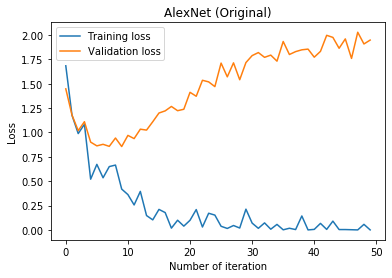

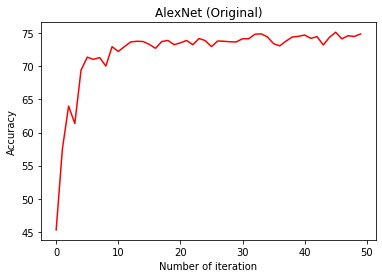

Mean time per epoch 16.60127462081999 seconds
Best accuracy: 75.14  Best training loss: 0.00020103454880882055  Best validation loss: 0.8554293078184128


In [0]:
# visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("AlexNet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("AlexNet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[1.6835790872573853, 1.175603985786438, 0.9885087609291077, 1.0834705829620361, 0.5205501317977905, 0.6725502014160156, 0.5350584387779236, 0.6497542858123779, 0.6653600335121155, 0.4189870059490204, 0.36256447434425354, 0.25640812516212463, 0.39531826972961426, 0.14752794802188873, 0.103270024061203, 0.210580974817276, 0.17804880440235138, 0.01845608651638031, 0.09959878772497177, 0.039013996720314026, 0.09906764328479767, 0.20886491239070892, 0.030130835250020027, 0.1711345613002777, 0.15228445827960968, 0.03762003779411316, 0.015244321897625923, 0.045352753251791, 0.019627027213573456, 0.21302169561386108, 0.07005283236503601, 0.016617432236671448, 0.07222004234790802, 0.0075284577906131744, 0.05671592801809311, 0.0012827396858483553, 0.017310313880443573, 0.003903617849573493, 0.143207713961601

## squeeze dat net

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.BatchNorm2d(96),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

# print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

FileNotFoundError: ignored

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 250
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.262885
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.009205
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.889318
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.827036
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.795875
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.752193
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.695312
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.671312
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.634310

Test set: Test loss: 1.5376, Accuracy: 2271/5000 (45%)

Better accuracy at Epoch 0: accuracy = 45.42%
Better loss at Epoch 0: loss = 1.5375925695896149%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.571716
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.536547
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.520602
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.465033
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.460390
Train Epoch: 1

KeyboardInterrupt: ignored

In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))

### testing adding layers

#### adding more fire layers

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
            # self.features = nn.Sequential(
            #     nn.Conv2d(3, 96, kernel_size=7, stride=2),
            #     nn.ReLU(inplace=True),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(96, 16, 64, 64),
            #     Fire(128, 16, 64, 64),
            #     Fire(128, 32, 128, 128),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(256, 32, 128, 128),
            #     Fire(256, 48, 192, 192),
            #     Fire(384, 48, 192, 192),
            #     Fire(384, 64, 256, 256),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(512, 64, 256, 256),
            #     Fire(512, 64, 256, 256),
                # nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(512, 64, 256, 256),
            #     Fire(512, 64, 256, 256),t
            # )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:
model = squeezenet1_0(num_classes=10)
model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 50
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.311227
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.218915
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 2.213744
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 2.190053
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 2.172718
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 2.163886
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 2.099876
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 2.091815
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 2.058563

Test set: Test loss: 2.0117, Accuracy: 1196/5000 (24%)

Better accuracy at Epoch 0: accuracy = 23.92%
Better loss at Epoch 0: loss = 2.011711308956146%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 2.055048
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 2.020186
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 2.015145
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 2.003264
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.990417
Train Epoch: 1 

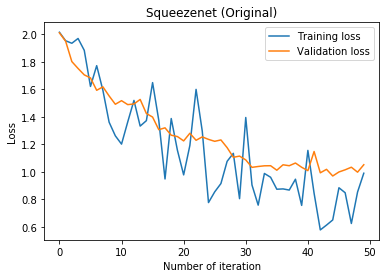

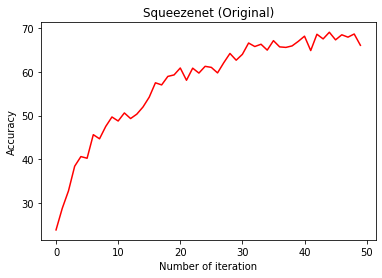

Mean time per epoch 24.850373377199986 seconds
Best accuracy: 69.04  Best training loss: 0.5774543285369873  Best validation loss: 0.9700033265352249


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")




#### adding layers 128 384

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 24, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 56, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
            # self.features = nn.Sequential(
            #     nn.Conv2d(3, 96, kernel_size=7, stride=2),
            #     nn.ReLU(inplace=True),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(96, 16, 64, 64),
            #     Fire(128, 16, 64, 64),
            #     Fire(128, 32, 128, 128),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(256, 32, 128, 128),
            #     Fire(256, 48, 192, 192),
            #     Fire(384, 48, 192, 192),
            #     Fire(384, 64, 256, 256),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(512, 64, 256, 256),
            #     Fire(512, 64, 256, 256),
                # nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(512, 64, 256, 256),
            #     Fire(512, 64, 256, 256),t
            # )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:
%%time

model = squeezenet1_0(num_classes=10)
model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.325768
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.297450
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 2.302597
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 2.302585
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 2.302584
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 2.302584
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 2.302584
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 2.302584
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 2.302584

Test set: Test loss: 2.3026, Accuracy: 512/5000 (10%)

Better accuracy at Epoch 0: accuracy = 10.24%
Better loss at Epoch 0: loss = 2.302584409713745%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 2.325610
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 2.302584
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 2.302584
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 2.302584
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 2.302584
Train Epoch: 1 [

KeyboardInterrupt: ignored

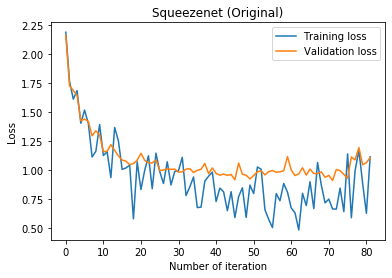

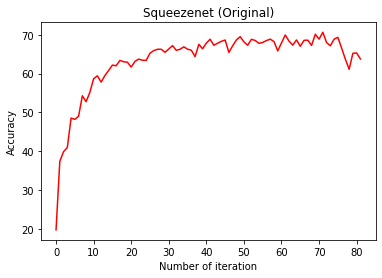

Mean time per epoch 25.150628093634158 seconds
Best accuracy: 70.64  Best training loss: 0.4841686189174652  Best validation loss: 0.9113111990690231


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")




#### adding layers 128 384 with batchnorm


In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.BatchNorm2d(96),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 24, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 56, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
            # self.features = nn.Sequential(
            #     nn.Conv2d(3, 96, kernel_size=7, stride=2),
            #     nn.ReLU(inplace=True),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(96, 16, 64, 64),
            #     Fire(128, 16, 64, 64),
            #     Fire(128, 32, 128, 128),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(256, 32, 128, 128),
            #     Fire(256, 48, 192, 192),
            #     Fire(384, 48, 192, 192),
            #     Fire(384, 64, 256, 256),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(512, 64, 256, 256),
            #     Fire(512, 64, 256, 256),
                # nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(512, 64, 256, 256),
            #     Fire(512, 64, 256, 256),t
            # )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:
%%time

model = squeezenet1_0(num_classes=10)
model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.324384
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.245353
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 2.199630
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 2.162025
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 2.129273
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 2.106871
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 2.109345
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 2.021423
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.969163

Test set: Test loss: 1.8752, Accuracy: 1118/5000 (22%)

Better accuracy at Epoch 0: accuracy = 22.36%
Better loss at Epoch 0: loss = 1.8752297365665436%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.943239
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.908922
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.875375
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.864101
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.873302
Train Epoch: 1

KeyboardInterrupt: ignored

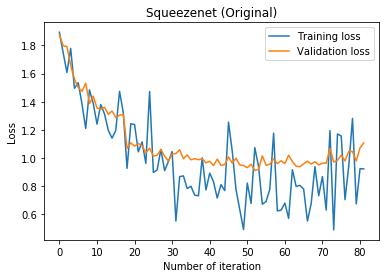

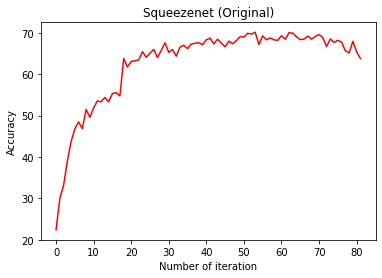

Mean time per epoch 26.48614233373168 seconds
Best accuracy: 70.12  Best training loss: 0.4895196557044983  Best validation loss: 0.9118266981840134


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")




#### removing fire layers

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        # self.bns1 = nn.BatchNorm2d(squeeze_planes)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        # self.bne1 = nn.BatchNorm2d(expand1x1_planes)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        # self.bne3 = nn.BatchNorm2d(expand3x3_planes)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                # nn.BatchNorm2d(96),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
            # self.features = nn.Sequential(
            #     nn.Conv2d(3, 96, kernel_size=7, stride=2),
            #     nn.ReLU(inplace=True),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(96, 16, 64, 64),
            #     Fire(128, 16, 64, 64),
            #     Fire(128, 32, 128, 128),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(256, 32, 128, 128),
            #     Fire(256, 48, 192, 192),
            #     Fire(384, 48, 192, 192),
            #     Fire(384, 64, 256, 256),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(512, 64, 256, 256),
            #     Fire(512, 64, 256, 256),
                # nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(512, 64, 256, 256),
            #     Fire(512, 64, 256, 256),t
            # )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:
%%time

model = squeezenet1_0(num_classes=10)
model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.288738
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.231754
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 2.222408
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 2.209078
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 2.172160
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 2.168398
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 2.173353
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 2.149965
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 2.124120

Test set: Test loss: 2.1001, Accuracy: 1268/5000 (25%)

Better accuracy at Epoch 0: accuracy = 25.36%
Better loss at Epoch 0: loss = 2.1001385867595674%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 2.103331
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 2.099842
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 2.107093
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 2.100324
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 2.086656
Train Epoch: 1

KeyboardInterrupt: ignored

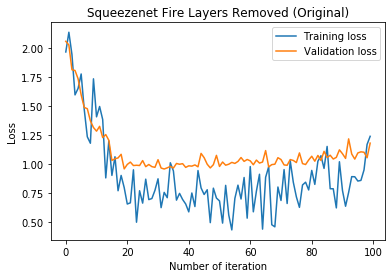

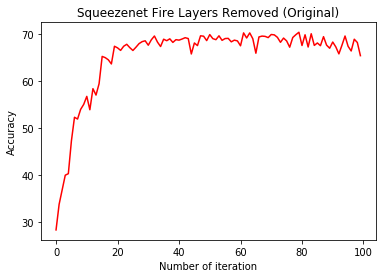

Mean time per epoch 18.847031471520005 seconds
Best accuracy: 70.34  Best training loss: 0.43348202109336853  Best validation loss: 0.9575561422109604


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet Fire Layers Removed (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet Fire Layers Removed (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")




#### removing fire modules with batchnorm

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.BatchNorm2d(96),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
            # self.features = nn.Sequential(
            #     nn.Conv2d(3, 96, kernel_size=7, stride=2),
            #     nn.ReLU(inplace=True),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(96, 16, 64, 64),
            #     Fire(128, 16, 64, 64),
            #     Fire(128, 32, 128, 128),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(256, 32, 128, 128),
            #     Fire(256, 48, 192, 192),
            #     Fire(384, 48, 192, 192),
            #     Fire(384, 64, 256, 256),
            #     nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(512, 64, 256, 256),
            #     Fire(512, 64, 256, 256),
                # nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            #     Fire(512, 64, 256, 256),
            #     Fire(512, 64, 256, 256),t
            # )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:
%%time

model = squeezenet1_0(num_classes=10)
model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.294660
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.225884
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 2.161388
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 2.100973
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 2.085238
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 2.071102
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 2.047601
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 2.004573
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 2.014063

Test set: Test loss: 2.0084, Accuracy: 1336/5000 (27%)

Better accuracy at Epoch 0: accuracy = 26.72%
Better loss at Epoch 0: loss = 2.008350933790207%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.989136
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.948203
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.960391
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.941399
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.906229
Train Epoch: 1 

KeyboardInterrupt: ignored

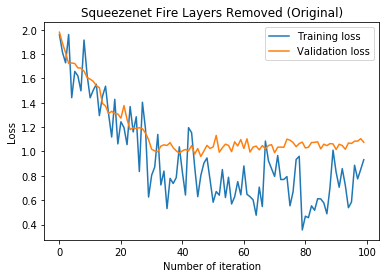

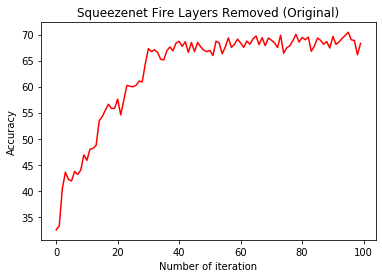

Mean time per epoch 19.29093309547009 seconds
Best accuracy: 70.44  Best training loss: 0.35574018955230713  Best validation loss: 0.9584466779232025


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet Fire Layers Removed (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet Fire Layers Removed (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")




In [0]:
# smaller network did not overfit as much

### squeeze ratio

#### 0.25

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.BatchNorm2d(96),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 64, 64, 64),
                Fire(128, 64, 64, 64),
                Fire(128, 128, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 128, 128, 128),
                Fire(256, 192, 192, 192),
                Fire(384, 192, 192, 192),
                Fire(384, 256, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 256, 256, 256),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:
%%time

model = squeezenet1_0(num_classes=10)
model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.148186
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 1.885410
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.779477
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.703525
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.632020
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.586779
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.537545
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.470280
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.436872

Test set: Test loss: 1.3482, Accuracy: 2711/5000 (54%)

Better accuracy at Epoch 0: accuracy = 54.22%
Better loss at Epoch 0: loss = 1.3482309436798097%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.346823
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.310505
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.333939
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.276143
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.235768
Train Epoch: 1

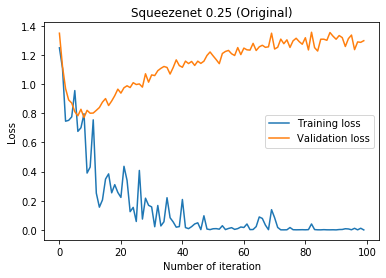

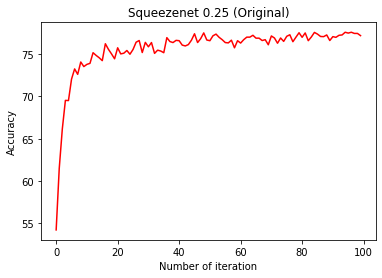

Mean time per epoch 53.290620637090015 seconds
Best accuracy: 77.6  Best training loss: 0.0002932357892859727  Best validation loss: 0.7705767253041267


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet 0.25 (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet 0.25 (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")




In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.BatchNorm2d(96),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 96, 64, 64),
                Fire(128, 96, 64, 64),
                Fire(128, 192, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 192, 128, 128),
                Fire(256, 288, 192, 192),
                Fire(384, 288, 192, 192),
                Fire(384, 384, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 384, 256, 256),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [10]:
%%time

model = squeezenet1_0(num_classes=10)
model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.108787
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 1.818557
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.722555
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.660857
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.589344
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.500019
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.493894
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.430662
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.374311

Test set: Test loss: 1.2930, Accuracy: 2784/5000 (56%)

Better accuracy at Epoch 0: accuracy = 55.68%
Better loss at Epoch 0: loss = 1.2929889118671418%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.279610
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.274536
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.254577
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.198966
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.163263
Train Epoch: 1

KeyboardInterrupt: ignored

In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet 0.25 (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet 0.25 (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


